In [1]:
# The script is loading the Andor-3 data from the .h5 files produced from the LCLSII DAQ
# Last ran 07/28/25

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def rebin_1d_mean(arr, fct):
    fct_rem = len(arr)%fct
    if fct_rem > 0:
        arr = arr[:-fct_rem]
    new_size = (np.floor(len(arr)/fct)).astype(int)
    old_size = len(arr)
    factor = old_size // new_size
    return arr.reshape(new_size, factor).mean(axis=1)

In [3]:
folderFiles = '/sdf/data/rfar/timodo/andordata/'
run29_files = [
    'ued1011086_Run0029.h5',
    'ued1011086_Run0029_part4.h5',
]
run29_paths = [os.path.join(folderFiles, f) for f in run29_files]

def load_andor_h5(filename):
    result = {'filename': filename}
    try:
        with h5py.File(filename, 'r') as data:
            timestamp = np.array(data['timestamp'])
            order_step = timestamp.argsort()
            ad_ufa = None
            if 'andor/full_area' in data:
                ad_ufa = np.array(data['andor/full_area'])[order_step]
            posi_stage = None
            if 'scan/UED:USR:MMN:06:06' in data:
                posi_stage = np.array(data['scan/UED:USR:MMN:06:06'])[order_step]
            elif 'epics/MOTR_AS01_MC06_CH6' in data:
                posi_stage = np.array(data['epics/MOTR_AS01_MC06_CH6'])[order_step]
            else:
                posi_stage = np.arange(len(timestamp))
            result.update({
                'timestamp': timestamp,
                'ad_ufa': ad_ufa,
                'posi_stage': posi_stage
            })
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        result.update({'timestamp': None, 'ad_ufa': None, 'posi_stage': None})
    return result

all_data = []
for fp in tqdm(run29_paths, desc="Loading .h5 files"):
    data = load_andor_h5(fp)
    all_data.append(data)

Loading .h5 files: 100%|██████████| 2/2 [00:00<00:00,  7.01it/s]


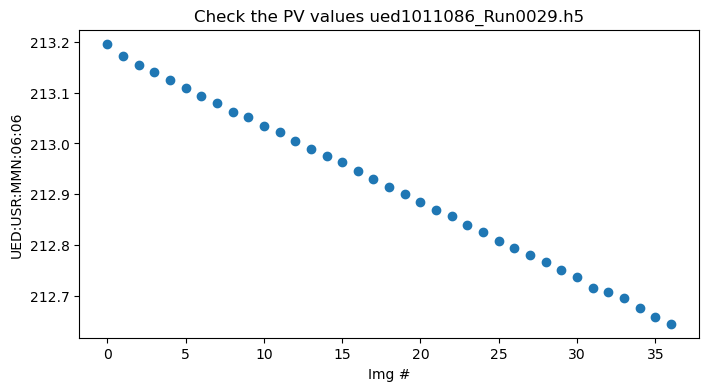

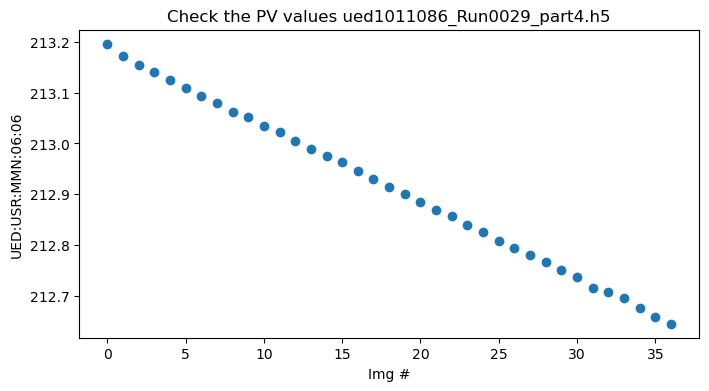

In [4]:
for data in all_data:
    posi_stage = data['posi_stage']
    fname = os.path.basename(data['filename'])
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(len(posi_stage)), posi_stage, 'o')
    plt.xlabel('Img #')
    plt.ylabel('UED:USR:MMN:06:06')
    plt.title(f"Check the PV values {fname}")
    plt.show()

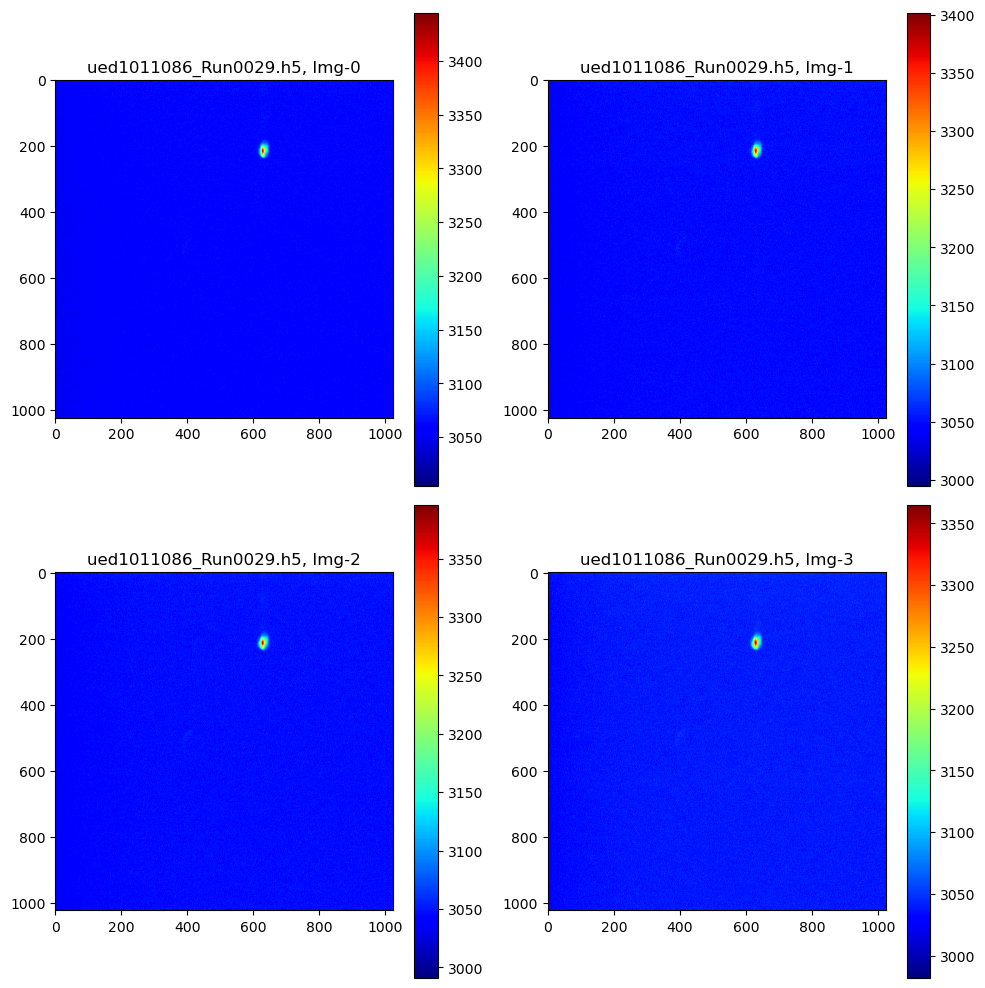

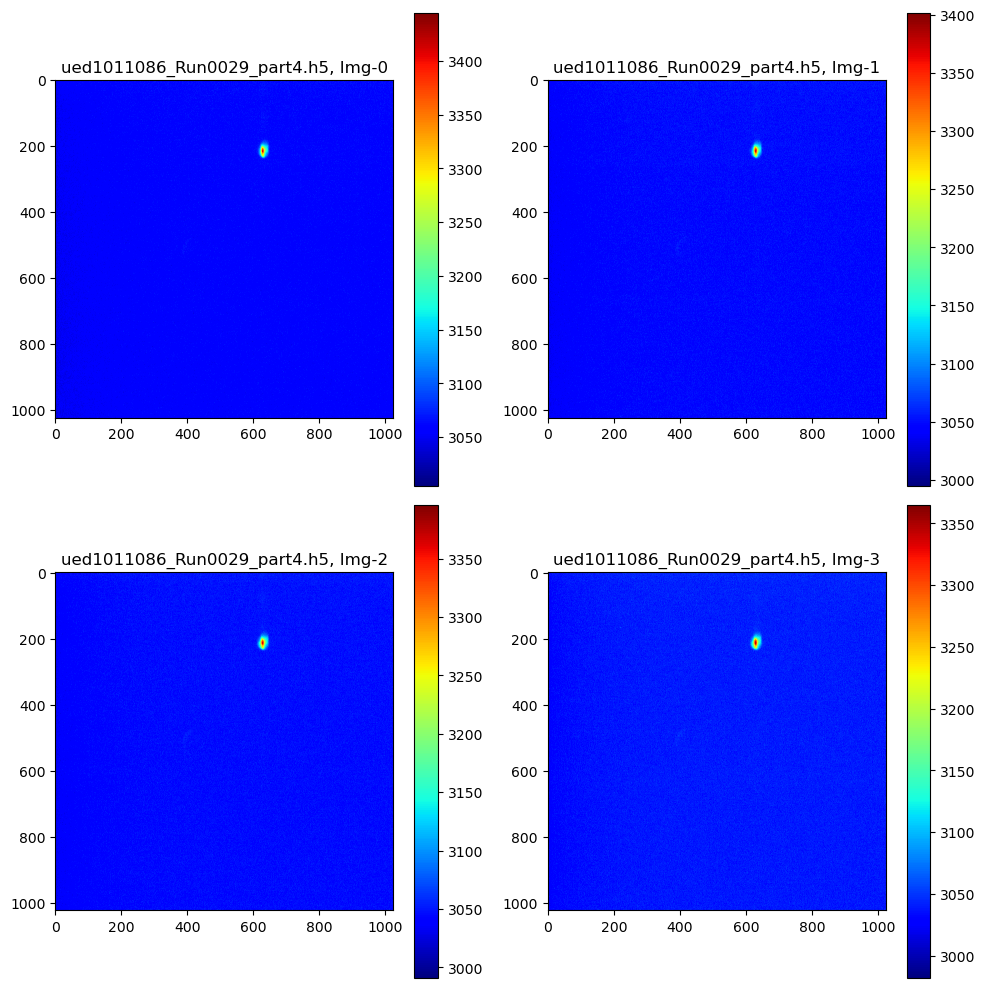

In [5]:
for data in all_data:
    ad_ufa = data['ad_ufa']
    fname = os.path.basename(data['filename'])
    if ad_ufa is not None:
        fig, axes = plt.subplots(2, 2, figsize=(10,10))
        for i in range(4):
            ax = axes[i//2, i%2]
            im = ax.imshow(ad_ufa[i], cmap='jet')
            ax.set_title(f"{fname}, Img-{i}")
            plt.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

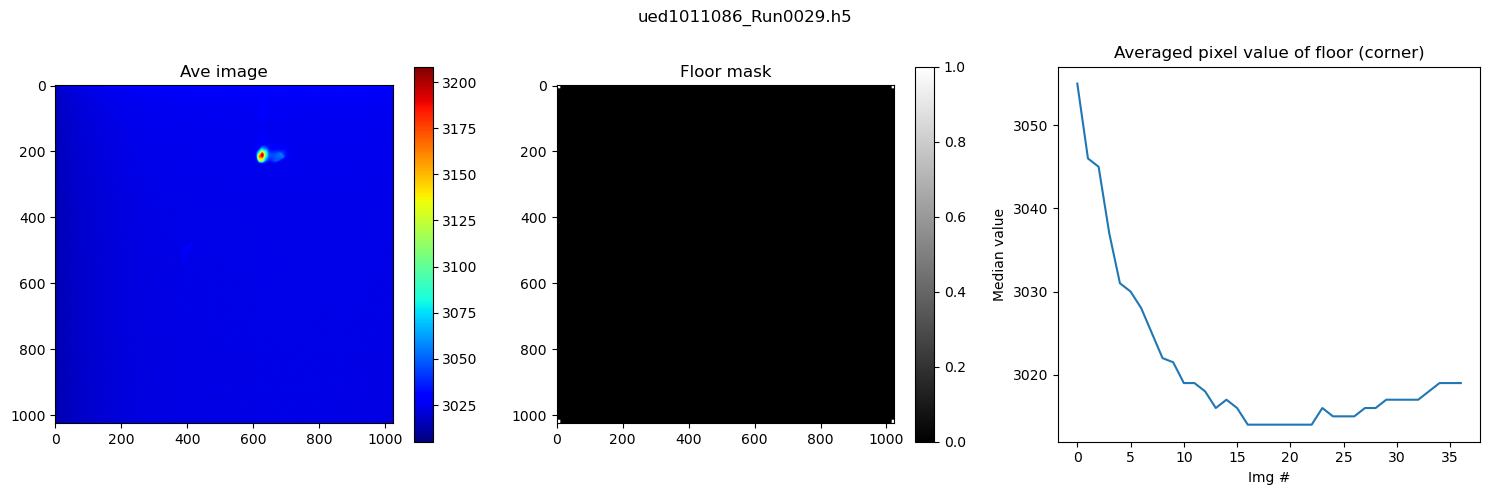

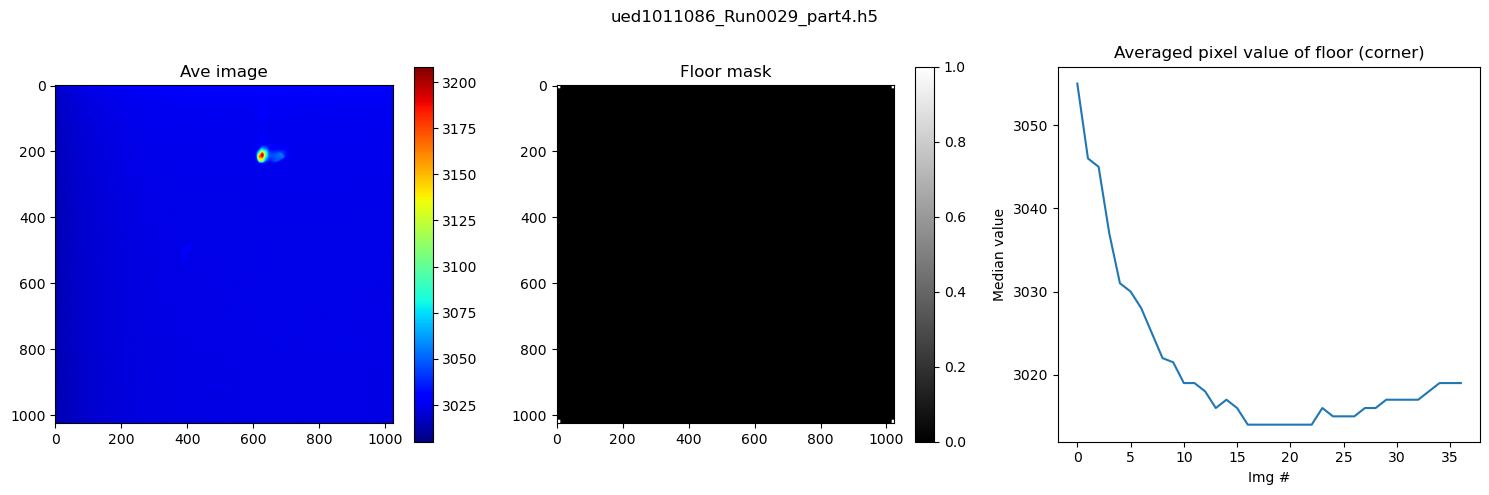

In [6]:
for data in all_data:
    ad_ufa = data['ad_ufa']
    fname = os.path.basename(data['filename'])
    if ad_ufa is not None:
        ave_img = ad_ufa.mean(axis=0)
        mask = np.zeros_like(ave_img, dtype=bool)
        mask[:10, :10] = True
        mask[-10:, :10] = True
        mask[:10, -10:] = True
        mask[-10:, -10:] = True
        floor_medians = [np.median(img[mask]) for img in ad_ufa]
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        im0 = axes[0].imshow(ave_img, cmap='jet')
        axes[0].set_title('Ave image')
        plt.colorbar(im0, ax=axes[0])
        im1 = axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Floor mask')
        plt.colorbar(im1, ax=axes[1])
        axes[2].plot(floor_medians)
        axes[2].set_title('Averaged pixel value of floor (corner)')
        axes[2].set_xlabel('Img #')
        axes[2].set_ylabel('Median value')
        plt.suptitle(fname)
        plt.tight_layout()
        plt.show()

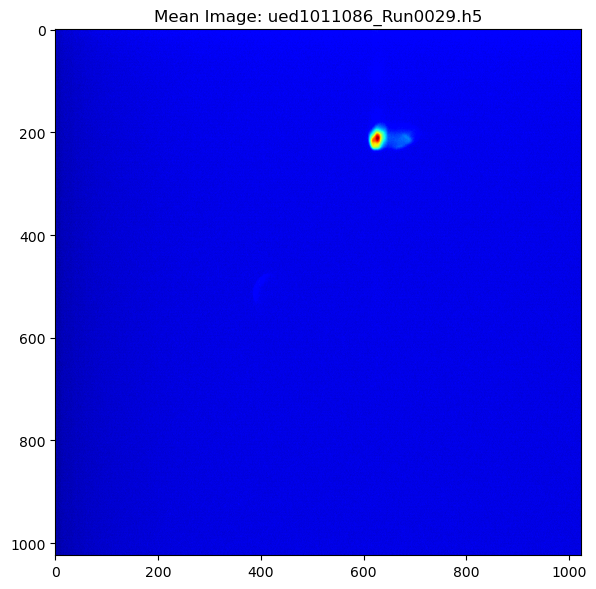

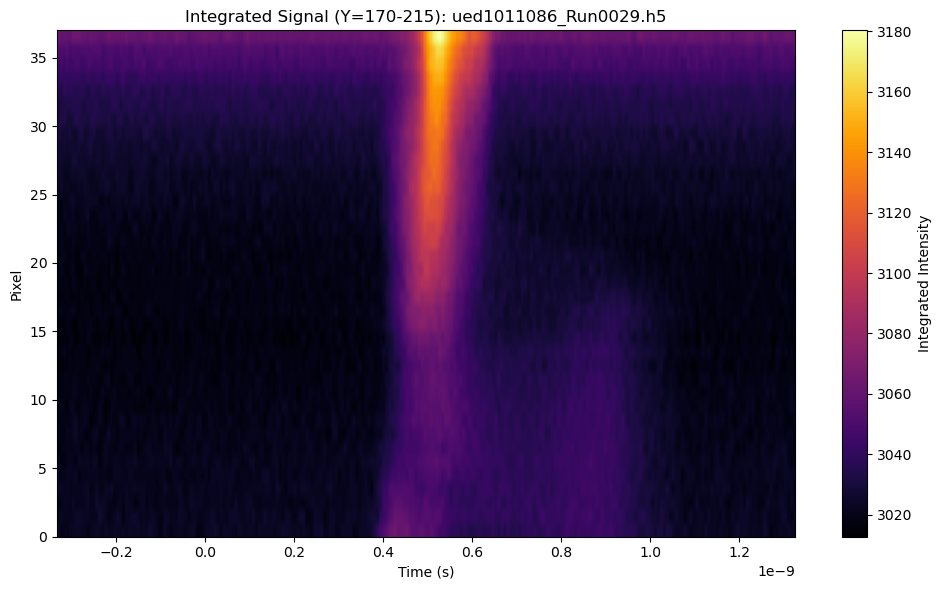

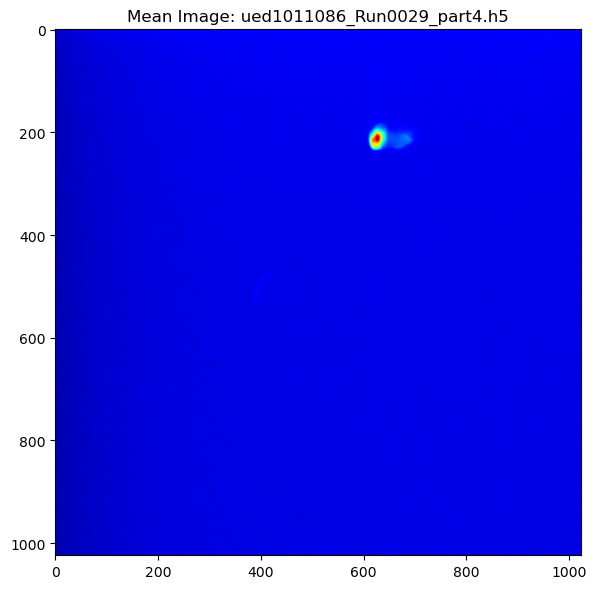

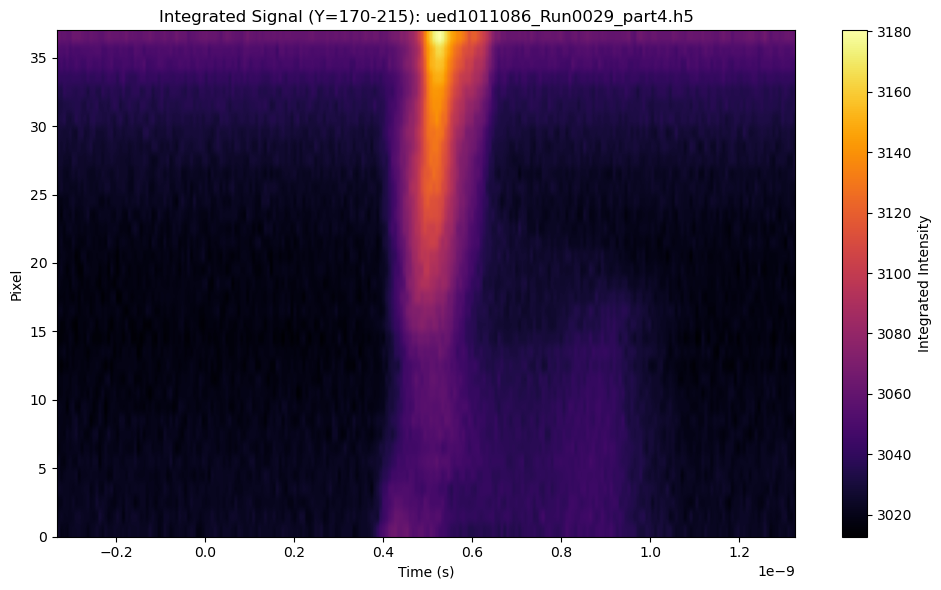

In [7]:
C = 3e8  # Speed of light (m/s)

for data in all_data:
    ad_ufa = data['ad_ufa']
    fname = os.path.basename(data['filename'])
    if ad_ufa is not None:
        plt.figure(figsize=(7,6))
        mean_img = ad_ufa.mean(axis=0)
        plt.imshow(mean_img, cmap='jet')
        plt.title(f"Mean Image: {fname}")
        plt.tight_layout()
        plt.show()

        y1, y2 = 170, 215
        x1, x2 = 500, 750

        inte_step = ad_ufa[:, y1:y2, :].mean(axis=1)
        n_x_pixels = inte_step.shape[1]
        PV = np.arange(n_x_pixels)
        T = (2 * (PV - 550)) / (1000 * C)  # Time in seconds

        idx1, idx2 = x1, x2
        time_window = T[idx1:idx2]
        inte_window = inte_step[:, idx1:idx2]

        plt.figure(figsize=(10, 6))
        plt.imshow(
            inte_window,
            cmap='inferno',
            aspect='auto',
            extent=[time_window[0], time_window[-1], 0, inte_step.shape[0]]
        )
        plt.title(f"Integrated Signal (Y={y1}-{y2}): {fname}")
        plt.xlabel("Time (s)")
        plt.ylabel("Pixel")
        plt.colorbar(label='Integrated Intensity')
        plt.tight_layout()
        plt.show()

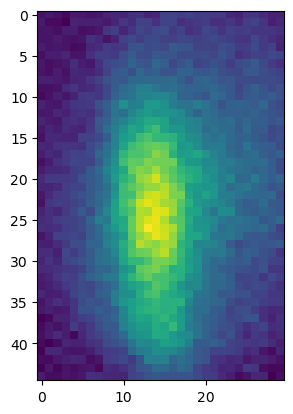

In [21]:
img = ad_ufa[0]
plt.imshow(img[190:235, 615:645])

In [22]:
def compute_com_x(image):
    total = image.sum()
    if total == 0:
        return np.nan
    indices = np.arange(image.shape[1])
    return (indices[None, :] * image).sum() / total

# Compute CoM (cropped region) and retain positional variables for all files
com_arrays = []
scan_vars = []
file_names = []

for data in all_data:
    ad_ufa = data['ad_ufa']
    posi_stage = data['posi_stage']
    fname = os.path.basename(data['filename'])
    if ad_ufa is not None:
        com = np.array([compute_com_x(img[190:235, 615:645]) for img in ad_ufa])
        com_arrays.append(com)
        scan_vars.append(posi_stage)
        file_names.append(fname)

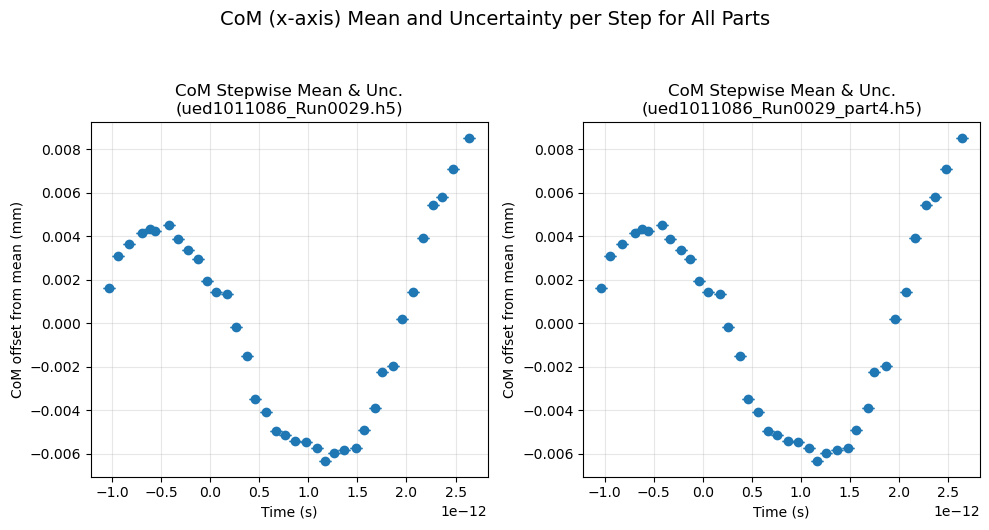

In [23]:
C = 3e8  # Speed of light (m/s)

def stepwise_stats(com, scan, mask, avg):
    steps = np.unique(scan[mask])
    means, stds, times = [], [], []
    for step in steps:
        step_mask = (scan == step) & mask
        vals = com[step_mask]
        if len(vals) > 0:
            means.append((np.nanmean(vals) - avg) * 100e-6 * 1000)
            stds.append(np.nanstd(vals) * 100e-6 * 1000)
            times.append(2 * (step - 212.8) / (1000 * C))
    return np.array(times), np.array(means), np.array(stds)

plt.figure(figsize=(5 * len(com_arrays), 5))
for i, (com, scan, fname) in enumerate(zip(com_arrays, scan_vars, file_names)):
    valid = np.isfinite(com) & (com > 0) & (com < 1000)
    avg = np.nanmean(com[valid]) if np.any(valid) else 0
    times, means, stds = stepwise_stats(com, scan, valid, avg)
    plt.subplot(1, len(com_arrays), i+1)
    plt.errorbar(times, means, yerr=stds, fmt='o', capsize=4, color='tab:blue', linestyle='none')
    plt.xlabel('Time (s)')
    plt.ylabel('CoM offset from mean (mm)')
    plt.title(f'CoM Stepwise Mean & Unc.\n({fname})')
    plt.grid(True, alpha=0.3)
plt.suptitle('CoM (x-axis) Mean and Uncertainty per Step for All Parts', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

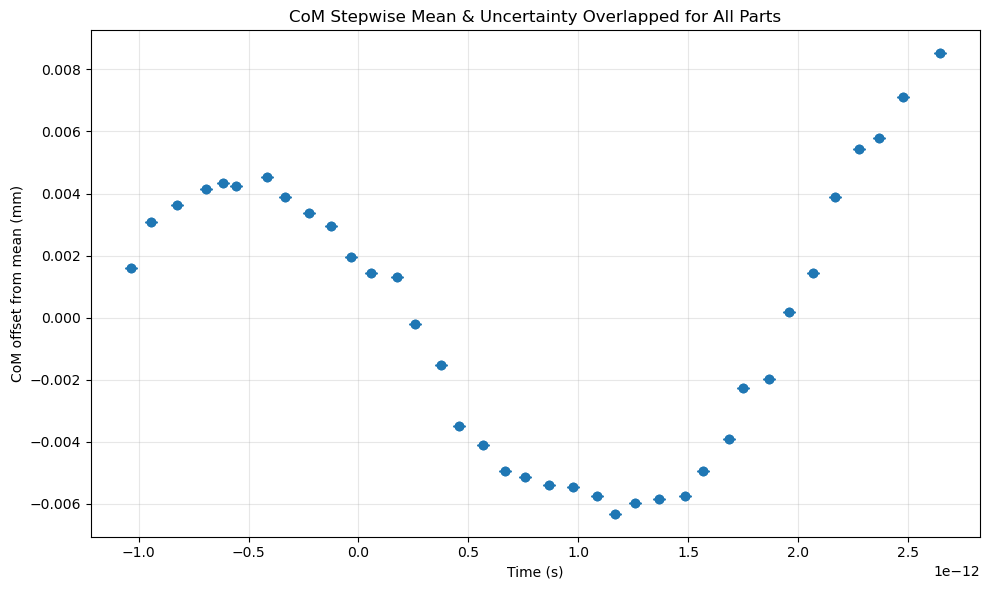

In [24]:
# Overlayed plot of all CoM stepwise mean & uncertainty, all in blue
plt.figure(figsize=(10, 6))

for i, (com, scan, fname) in enumerate(zip(com_arrays, scan_vars, file_names)):
    valid = np.isfinite(com) & (com > 0) & (com < 1000)
    avg = np.nanmean(com[valid]) if np.any(valid) else 0
    times, means, stds = stepwise_stats(com, scan, valid, avg)
    plt.errorbar(times, means, yerr=stds, fmt='o', capsize=4,
                 color='tab:blue', linestyle='none')

plt.xlabel('Time (s)')
plt.ylabel('CoM offset from mean (mm)')
plt.title('CoM Stepwise Mean & Uncertainty Overlapped for All Parts')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

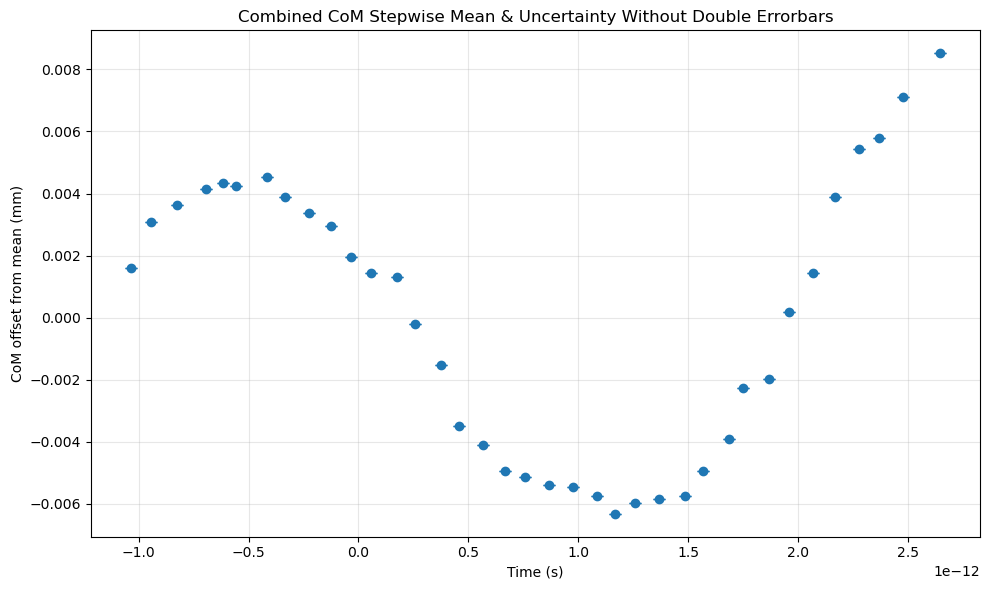

In [25]:
# Combine all CoM data across parts before calculating stepwise stats
all_times = []
all_values = []

for com, scan in zip(com_arrays, scan_vars):
    valid = np.isfinite(com) & (com > 0) & (com < 1000)
    all_times.append(scan[valid])
    all_values.append(com[valid])

all_times_concat = np.concatenate(all_times)
all_values_concat = np.concatenate(all_values)

# Recalculate stepwise stats on all combined data
avg_all = np.nanmean(all_values_concat) if all_values_concat.size > 0 else 0
combined_times, combined_means, combined_stds = stepwise_stats(
    all_values_concat, all_times_concat, np.full_like(all_values_concat, True, dtype=bool), avg_all
)

plt.figure(figsize=(10, 6))
plt.errorbar(combined_times, combined_means, yerr=combined_stds, fmt='o', capsize=4, color='tab:blue', linestyle='none')
plt.xlabel('Time (s)')
plt.ylabel('CoM offset from mean (mm)')
plt.title('Combined CoM Stepwise Mean & Uncertainty Without Double Errorbars')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()